In [1]:
# Savage-Dickey density ratio test for nested models
# Verdinelli, I., & Wasserman, L. (1995). Computing Bayes factors using a generalization of the Savage-Dickey density ratio. Journal of the American Statistical Association, 90(430), 614-618.

### Interpretation of the Bayes factor in terms of simple (nested) or complex model
def interpret_bayes_factor(bf):
    if bf < 1:
        interpretation = "Evidence favors the simpler model"
    elif 1 <= bf < 3:
        interpretation = "Anecdotal evidence for the complex model"
    elif 3 <= bf < 10:
        interpretation = "Substantial evidence for the complex model"
    elif 10 <= bf < 30:
        interpretation = "Strong evidence for the complex model"
    elif 30 <= bf < 100:
        interpretation = "Very strong evidence for the complex model"
    else:
        interpretation = "Decisive evidence for the complex model"
    print(f"Bayes Factor: {bf:.3g} - {interpretation}")
    


In [2]:
### Imports
import re
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t as t_test
from scipy.stats import norm
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
### Color list of dark organges in named colors by number
dark_oranges = sns.color_palette("Oranges", n_colors=9)[4:]
dark_purples = sns.color_palette("Purples", n_colors=9)[4:]
dark_greens = sns.color_palette("Greens", n_colors=9)[4:]

In [3]:
### Open data
path = "/home/jmindlin/BF_codes/data/DCENT_GMST_statistics.txt"

# 1) Find the header line ("Year,GMST (°C),...")
with open(path, "r", encoding="utf-8") as f:
    lines = f.readlines()

start = next(i for i, line in enumerate(lines) if line.strip().startswith("Year,"))


# 2) Read CSV from that header line onward; allow commas with spaces
df = pd.read_csv(
    path,
    skiprows=start,               # start at the header line
    engine="python",
    sep=r"\s*,\s*",               # split on commas, ignoring surrounding spaces
    comment=None
)

# 3) Clean column names to something easy to use
rename_map = {
    "Year": "year",
    "GMST (°C)": "gmst",
    "1 s.d. (°C)": "gmst_sd",
    "GMST non infilled (°C)": "gmst_noninf",
    "1 s.d. (°C; non  infilled)": "gmst_noninf_sd",
}
# in case of double spaces etc., normalize header keys first
df.columns = [re.sub(r"\s+", " ", c).strip() for c in df.columns]
rename_map_norm = {re.sub(r"\s+", " ", k).strip(): v for k, v in rename_map.items()}
df = df.rename(columns=rename_map_norm)

# 4) Ensure numeric dtypes
for c in ["year", "gmst", "gmst_sd", "gmst_noninf", "gmst_noninf_sd"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# 5) Convert to xarray (optional)
ds = xr.Dataset(
    {
        "GMST": (["year"], df["gmst"].values),
        "GMST_sd": (["year"], df["gmst_sd"].values),
        "GMST_non_infilled": (["year"], df["gmst_noninf"].values),
        "GMST_non_infilled_sd": (["year"], df["gmst_noninf_sd"].values),
    },
    coords={"year": df["year"].values.astype(int)},
)
ds_full = ds.copy()
ds = ds - ds.sel(year=slice('1951','1980')).mean(dim='year')

In [5]:
# --- Shape data ---
t = ds.sel(year=slice('1950','2024')).year
y = ds['GMST'].sel(year=slice('1950','2024')).values
n = len(y)


### Linear model
X_lin = np.column_stack([np.ones(n), t])
beta_lin, *_ = np.linalg.lstsq(X_lin, y, rcond=None)
yhat_lin = X_lin @ beta_lin
resid_lin = y - yhat_lin

### Quadratic model
X_quad = np.column_stack([np.ones(n), t, t**2])
beta_quad, *_ = np.linalg.lstsq(X_quad, y, rcond=None)
yhat_quad = X_quad @ beta_quad
resid_quad = y - yhat_quad



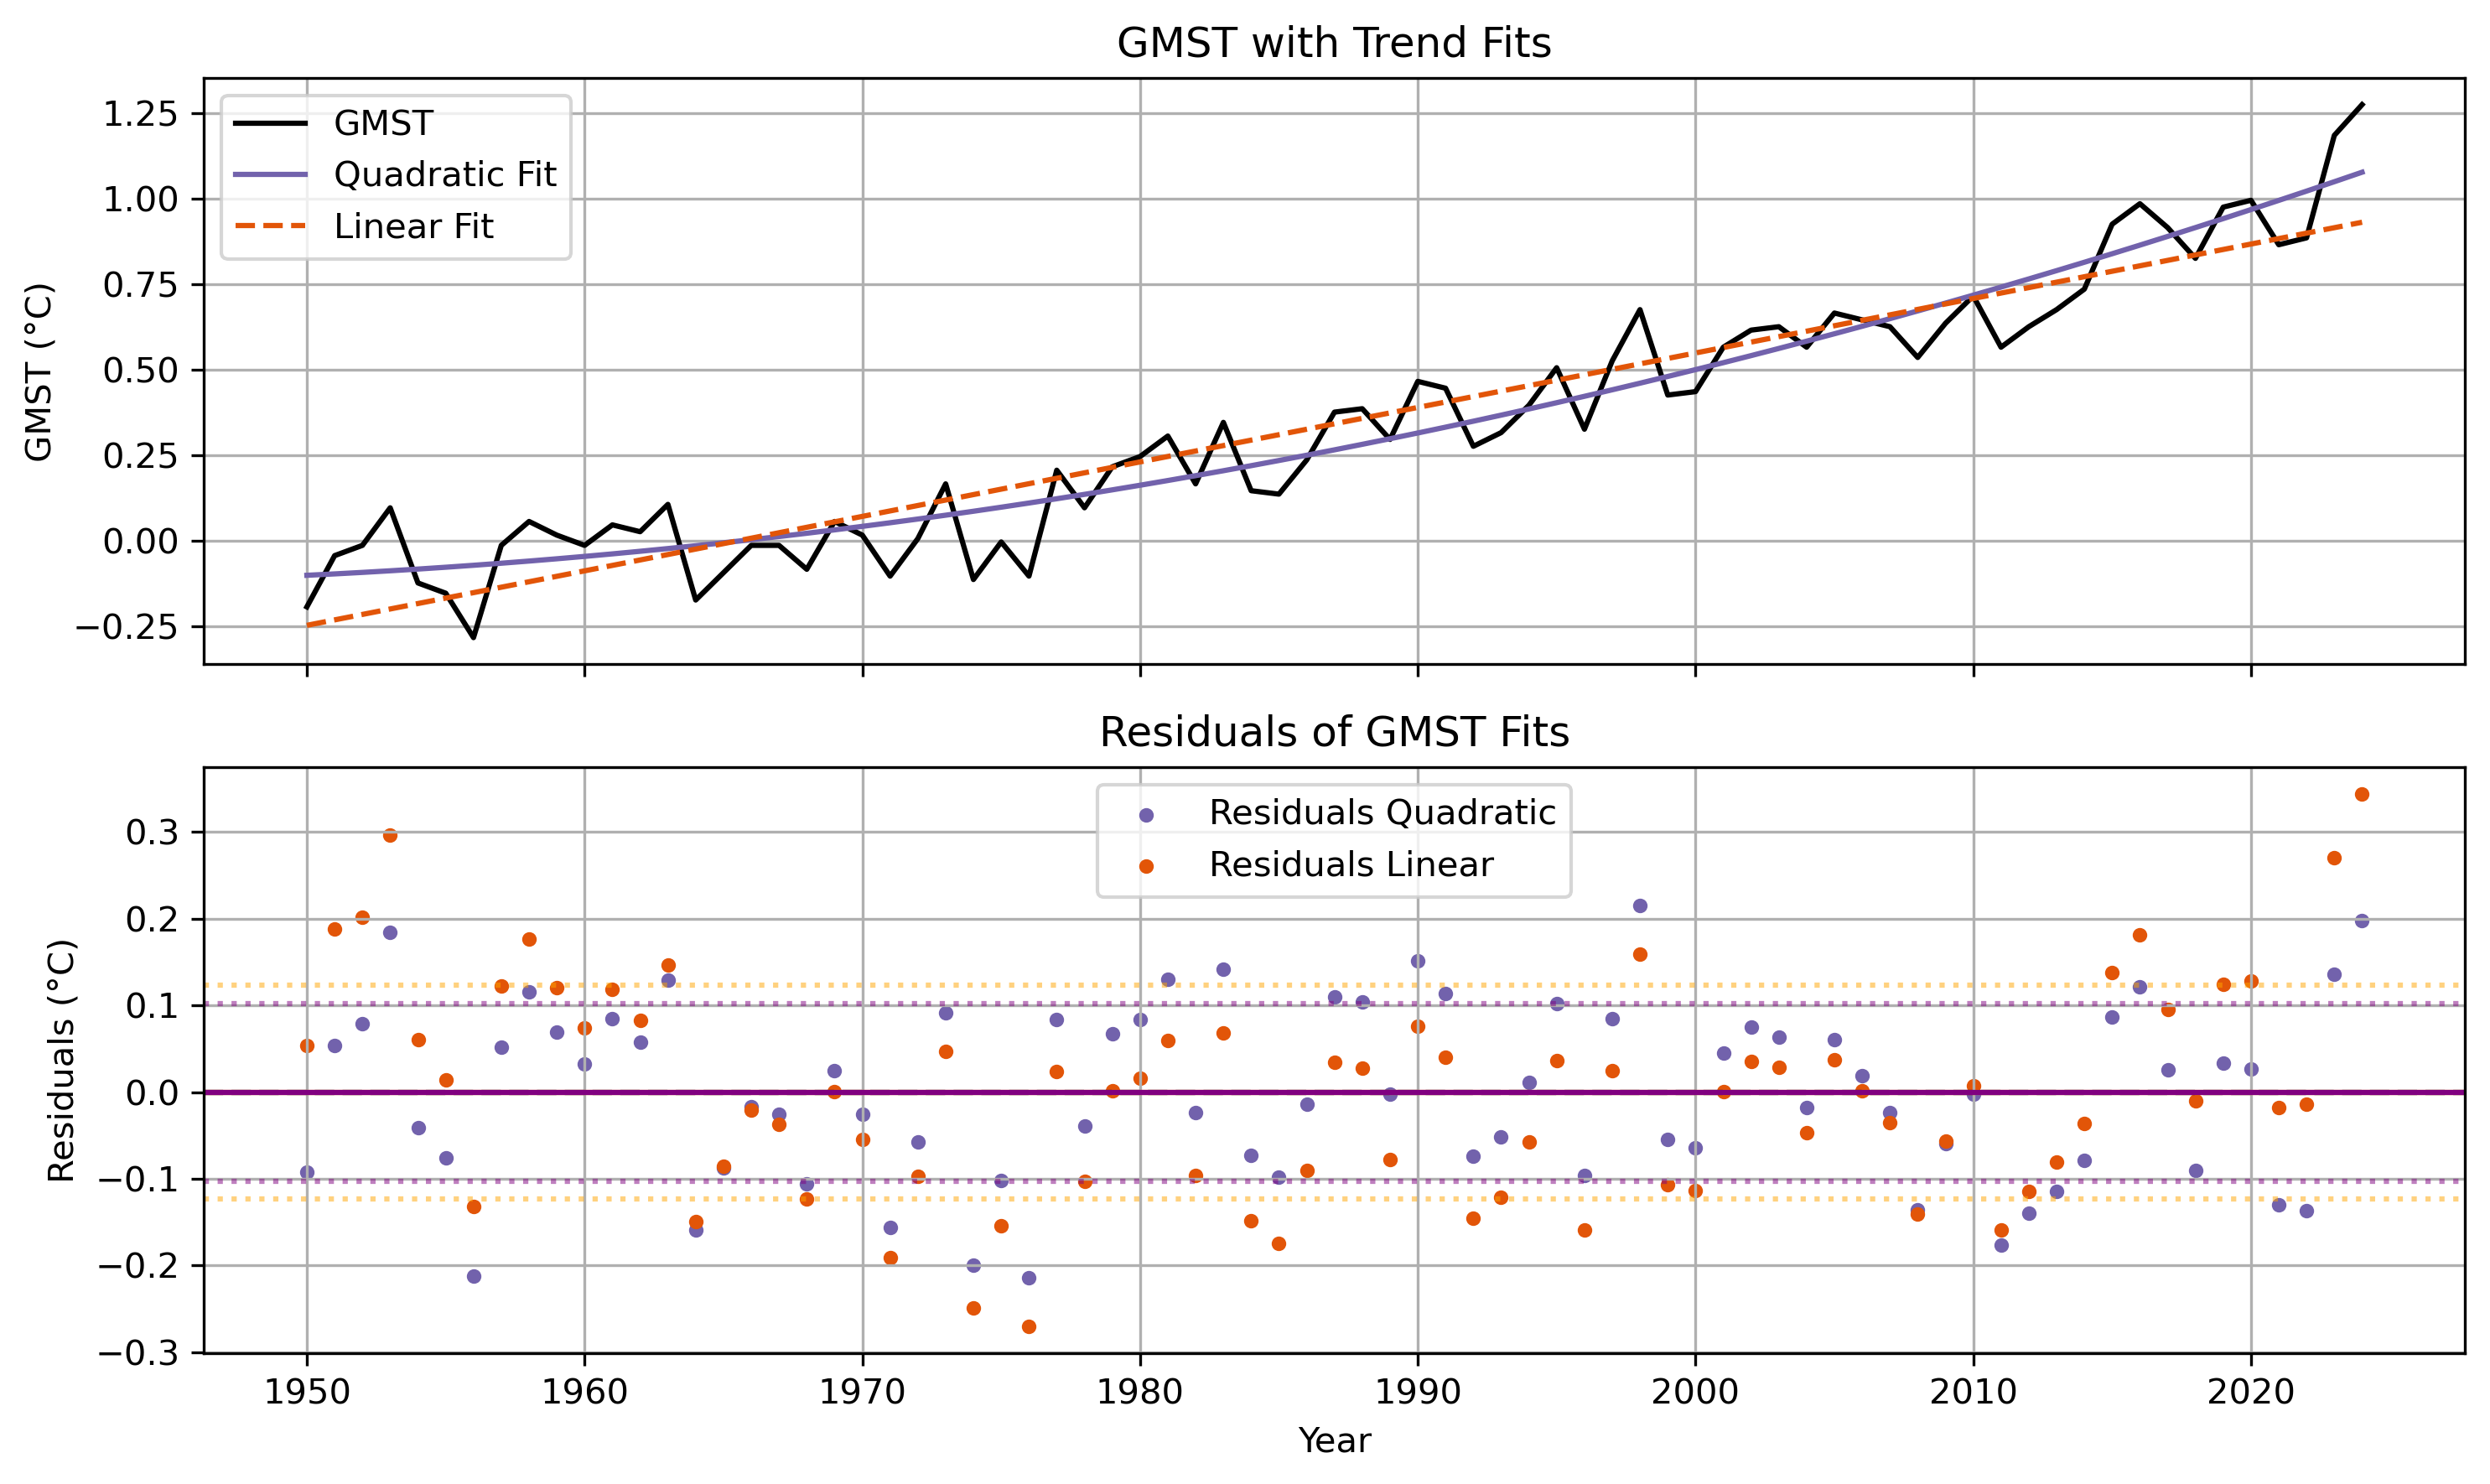

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True,dpi=300)

# === Panel 1: GMST Fits ===
axs[0].plot(t, y, label='GMST', color='black')
axs[0].plot(t, yhat_quad, label='Quadratic Fit', color=dark_purples[2])
axs[0].plot(t, yhat_lin, label='Linear Fit', linestyle='--',color=dark_oranges[2])

axs[0].set_ylabel('GMST (°C)')
axs[0].set_title('GMST with Trend Fits')
axs[0].legend()
axs[0].grid()

# === Panel 2: Residuals ===
axs[1].scatter(t, resid_quad, label='Residuals Quadratic', s=10, color=dark_purples[2])
axs[1].scatter(t, resid_lin, label='Residuals Linear', s=10, color=dark_oranges[2])

axs[1].axhline(0, color='k', linestyle='--')

# Residual stats: mean ± std for each model
for resid, color in zip(
    [resid_lin,resid_quad],
    ['Orange', 'purple']
):
    mean = np.mean(resid)
    std = np.std(resid)
    axs[1].axhline(mean, color=color, linestyle='-')
    axs[1].axhline(mean + std, color=color, linestyle=':', alpha=0.5)
    axs[1].axhline(mean - std, color=color, linestyle=':', alpha=0.5)

axs[1].set_xlabel('Year')
axs[1].set_ylabel('Residuals (°C)')
axs[1].set_title('Residuals of GMST Fits')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()


Bayes Factor (Linear vs Quadratic) via Savage-Dickey: 244.9090844437109
Quadratic coefficient (beta): 0.0001626424784317848
Quadratic coefficient standard error (se): 2.8790703426532833e-05
t-statistic for Quadratic coefficient: 5.649131805577815
p-value for Quadratic coefficient: 3.0174440657226853e-07


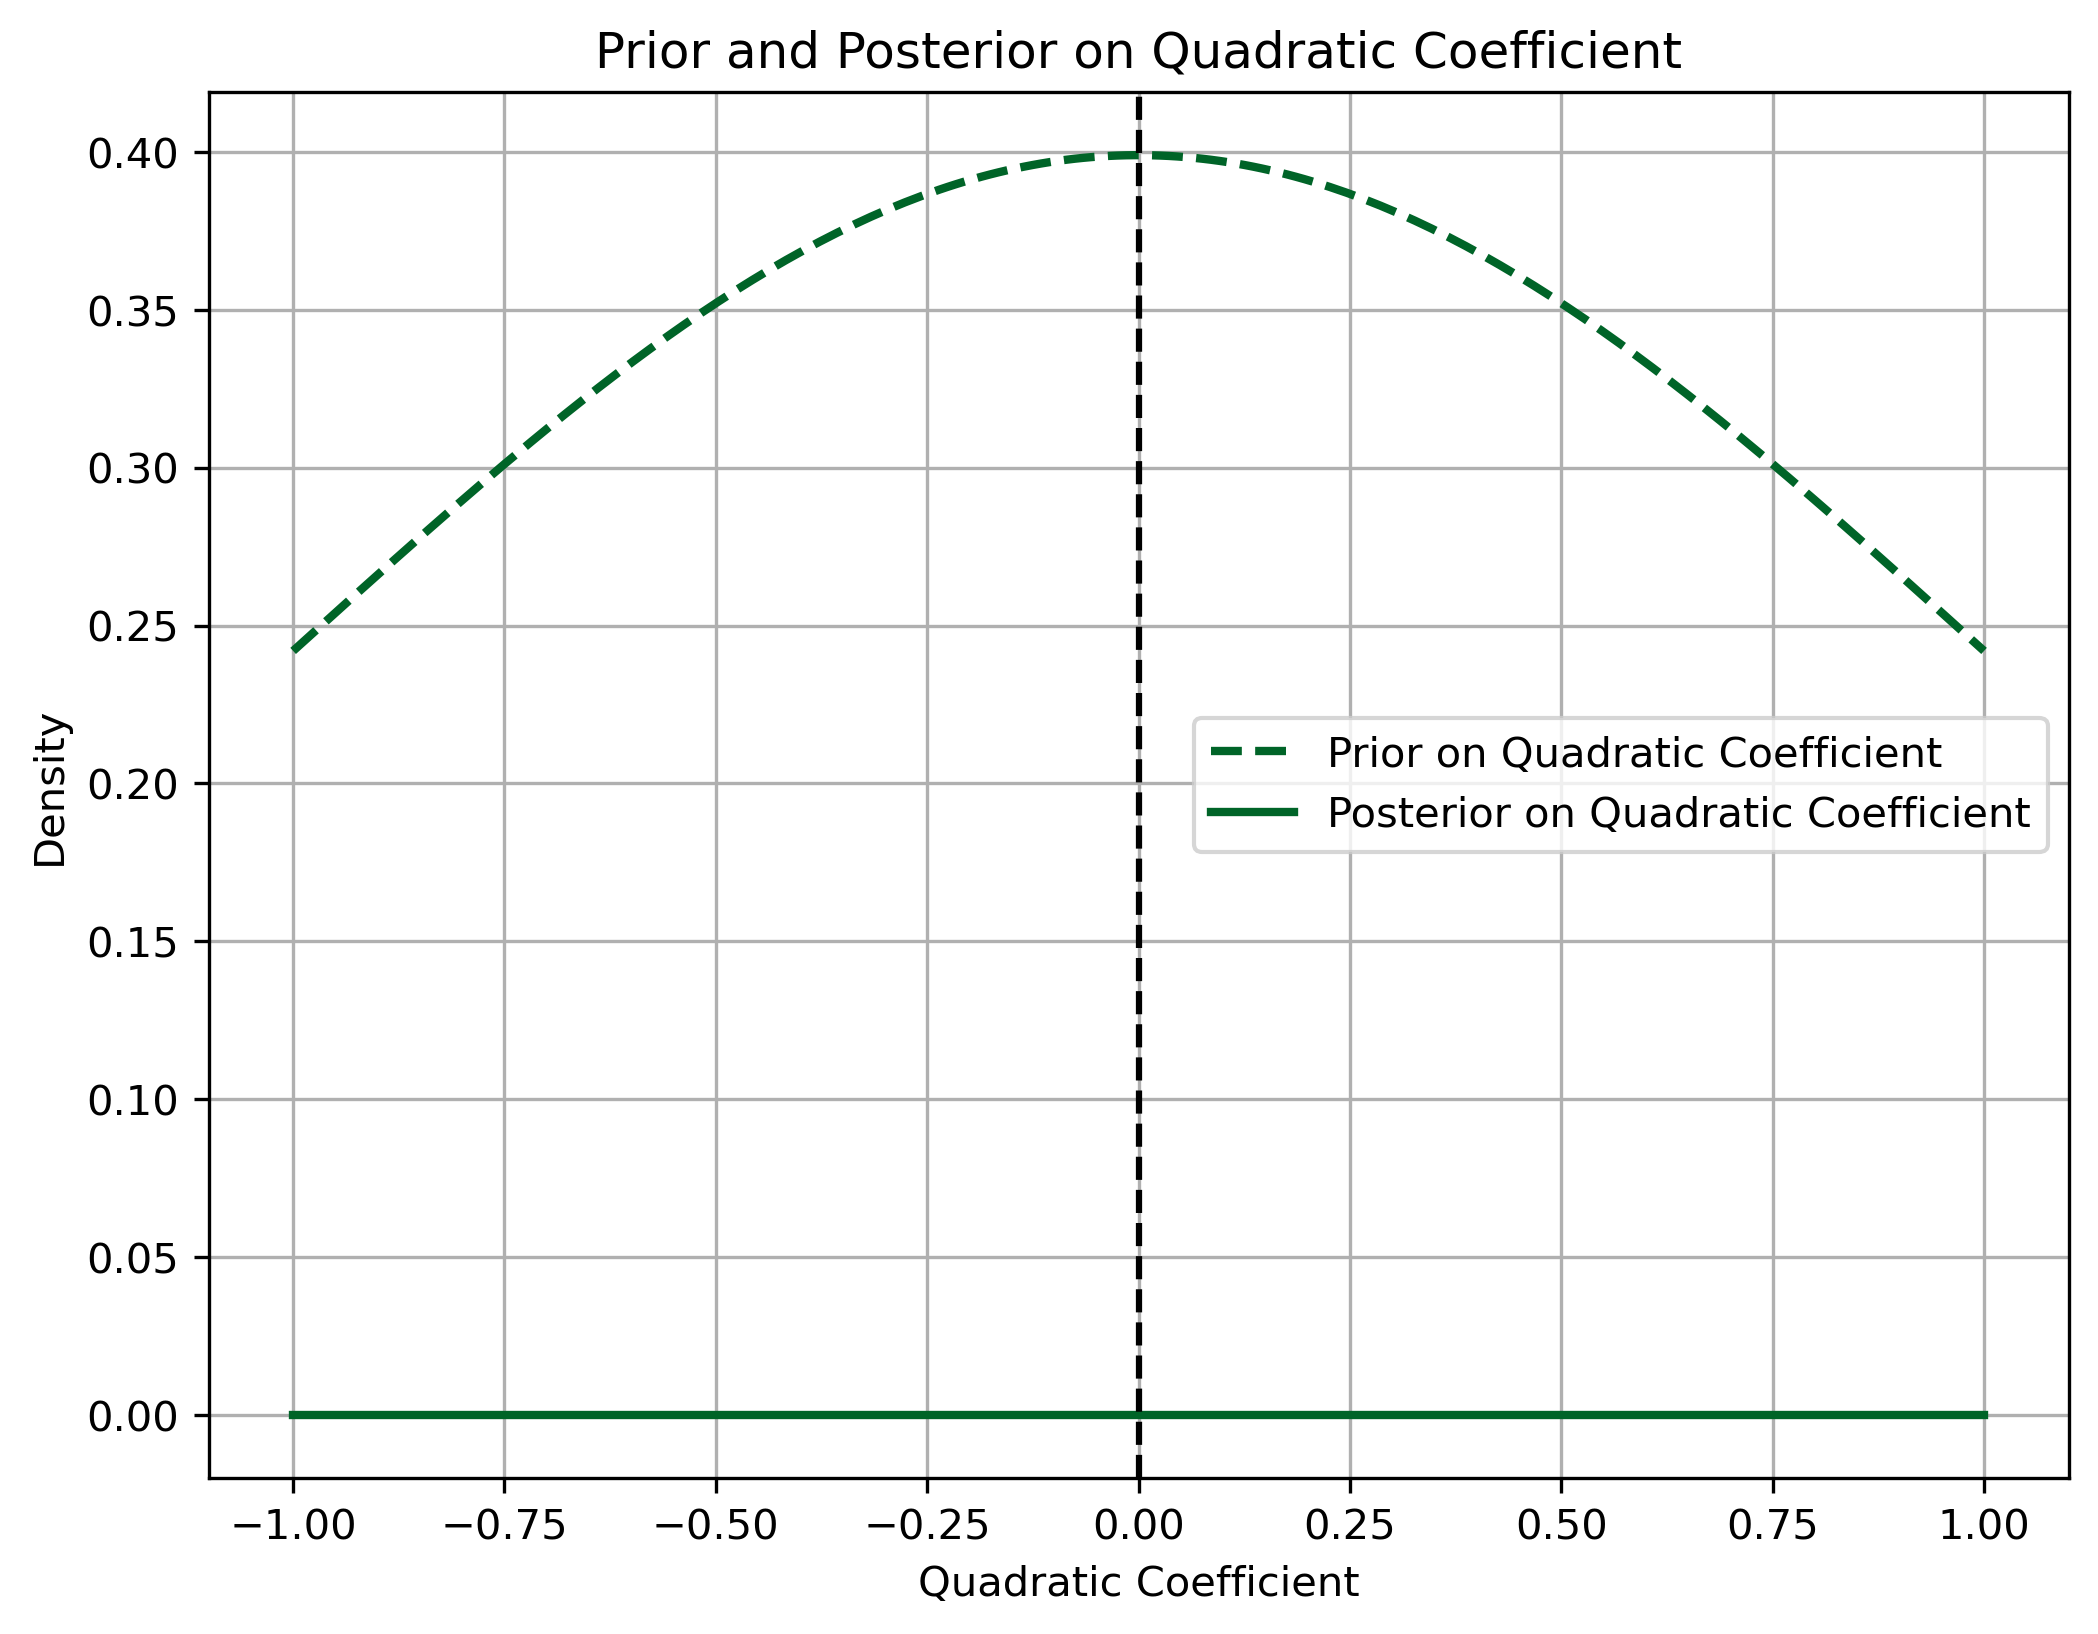

Bayes Factor: 245 - Decisive evidence for the complex model


In [17]:
### Test the two nested hypotheses, Linear vs Quadratic, via Bayes factor (Savage Dickey density ratio) test
# Prior on Quadratic coefficient: Normal(0, 1)

prior_quad = norm(loc=0, scale=1)
# Posterior on Quadratic coefficient: Normal(beta, se)
se_quad = np.sqrt(np.sum(resid_quad**2) / (n - X_quad.shape[1])) * np.sqrt(np.linalg.inv(X_quad.T @ X_quad)[-1, -1])
posterior_quad = norm(loc=beta_quad[-1], scale=se_quad)
# Bayes factor: prior density at 0 / posterior density at 0
bf_savage_dickey_quad = prior_quad.pdf(0) / posterior_quad.pdf(0)
print("Bayes Factor (Linear vs Quadratic) via Savage-Dickey:", bf_savage_dickey_quad)
print("Quadratic coefficient (beta):", beta_quad[-1])
print("Quadratic coefficient standard error (se):", se_quad)
### Frequentist test: t-test on Quadratic coefficient

t_stat_quad = beta_quad[-1] / se_quad
p_value_quad = 2 * (1 - t_test.cdf(np.abs(t_stat_quad), df=n - X_quad.shape[1]))
print("t-statistic for Quadratic coefficient:", t_stat_quad)
print("p-value for Quadratic coefficient:", p_value_quad)
plt.figure(figsize=(8,6), dpi=300)
x = np.linspace(-1, 1, 200)
plt.plot(x, prior_quad.pdf(x), label='Prior on Quadratic Coefficient', linestyle='--',linewidth=2,color=dark_greens[4])
plt.plot(x, posterior_quad.pdf(x), label='Posterior on Quadratic Coefficient', linewidth=2,color=dark_greens[4])
plt.axvline(0, color='k', linestyle='--')
plt.xlabel('Quadratic Coefficient')
plt.ylabel('Density')
plt.title('Prior and Posterior on Quadratic Coefficient')
plt.legend()
plt.grid()
plt.show()

interpret_bayes_factor(bf_savage_dickey_quad)  

In [9]:
### Quadratic coefficient
print("Quadratic coefficient (beta):", beta_quad[-1])

Quadratic coefficient (beta): 0.00016264247843200685


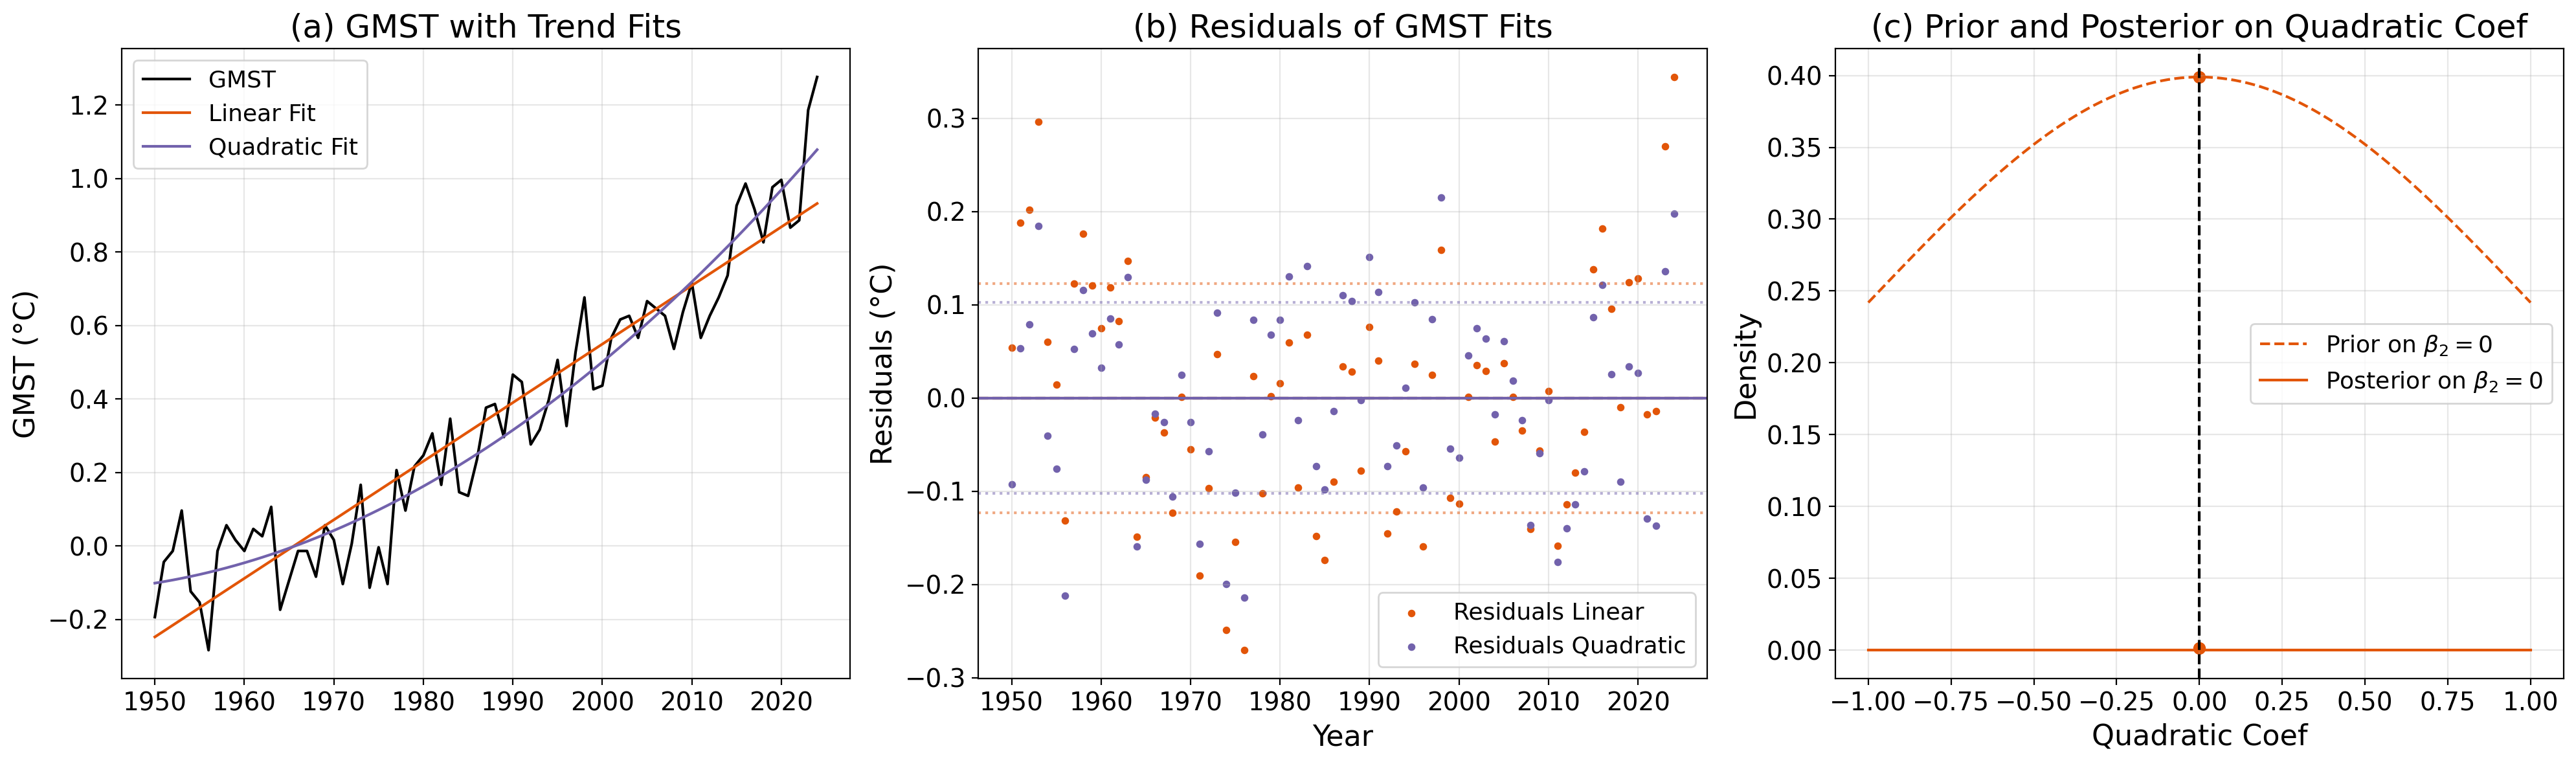

In [15]:
# === FONT SETTINGS ===
TITLE_FONTSIZE = 18
LABEL_FONTSIZE = 16
TICK_FONTSIZE = 14
LEGEND_FONTSIZE = 13

# === FIG 
fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharex=False, dpi=200)

# === Panel (a): GMST Fits ===
axs[0].plot(t, y, label='GMST', color='black')
axs[0].plot(t, yhat_lin, label='Linear Fit', color=dark_oranges[2])
axs[0].plot(t, yhat_quad, label='Quadratic Fit', color=dark_purples[2])
axs[0].set_ylabel('GMST (°C)', fontsize=LABEL_FONTSIZE)
axs[0].set_title('(a) GMST with Trend Fits', fontsize=TITLE_FONTSIZE)
axs[0].tick_params(axis='both', labelsize=TICK_FONTSIZE)
axs[0].legend(fontsize=LEGEND_FONTSIZE)
axs[0].grid(alpha=0.3)

# === Panel (b): Residuals ===
axs[1].scatter(t, resid_lin, label='Residuals Linear', s=10, color=dark_oranges[2])
axs[1].scatter(t, resid_quad, label='Residuals Quadratic', s=10, color=dark_purples[2])
axs[1].axhline(0, color='k', linestyle='--')

# Residual stats: mean ± std for each model
for resid, color in zip(
    [resid_lin, resid_quad],
    [dark_oranges[2], dark_purples[2]]
):
    mean = np.mean(resid)
    std = np.std(resid)
    axs[1].axhline(mean, color=color, linestyle='-')
    axs[1].axhline(mean + std, color=color, linestyle=':', alpha=0.5)
    axs[1].axhline(mean - std, color=color, linestyle=':', alpha=0.5)

axs[1].set_xlabel('Year', fontsize=LABEL_FONTSIZE)
axs[1].set_ylabel('Residuals (°C)', fontsize=LABEL_FONTSIZE)
axs[1].set_title('(b) Residuals of GMST Fits', fontsize=TITLE_FONTSIZE)
axs[1].tick_params(axis='both', labelsize=TICK_FONTSIZE)
axs[1].legend(fontsize=LEGEND_FONTSIZE)
axs[1].grid(alpha=0.3)

# === Panel (c): Prior and Posterior on Quadratic Coefficient ===
x_quad = np.linspace(-1, 1, 200)
axs[2].plot(x_quad, prior_quad.pdf(x_quad), label=r'Prior on $\beta_2=0$',
               linestyle='--', color=dark_oranges[2])
axs[2].plot(x_quad, posterior_quad.pdf(x_quad), label=r'Posterior on $\beta_2=0$',
              color=dark_oranges[2])
axs[2].scatter(0, prior_quad.pdf(0), color=dark_oranges[2])
axs[2].scatter(0, posterior_quad.pdf(0), color=dark_oranges[2])
axs[2].axvline(0, color='k', linestyle='--')
axs[2].set_xlabel('Quadratic Coef', fontsize=LABEL_FONTSIZE)
axs[2].set_ylabel('Density', fontsize=LABEL_FONTSIZE)
axs[2].set_title('(c) Prior and Posterior on Quadratic Coef', fontsize=TITLE_FONTSIZE)
axs[2].tick_params(axis='both', labelsize=TICK_FONTSIZE)
axs[2].legend(fontsize=LEGEND_FONTSIZE)
axs[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
### Bayes factor, prior and posterior at beta_2 = 0
print("Bayes Factor (Linear vs Quadratic) via Savage-Dickey:", bf_savage_dickey_quad)

Bayes Factor (Linear vs Quadratic) via Savage-Dickey: 244.9090844437109
